<a href="https://colab.research.google.com/github/jsuj1th/Buildings-Classification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir_train = pathlib.Path("drive/MyDrive/data2024Sep/data2024Sep/train")
data_dir_val =   pathlib.Path("drive/MyDrive/data2024Sep/data2024Sep/validation")



train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_val,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4330 files belonging to 15 classes.
Found 1218 files belonging to 15 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['cat07 MasAptMotel', 'cat08 S_Retail', 'cat09 S_ProfBldg', 'cat10 StripMall', 'cat11 L_ShopMall', 'cat12 L_IsoRetail', 'cat13 AutoShow', 'cat14 AutoService', 'cat17 LowRise', 'cat18 MidRise', 'cat19 HighRise', 'cat20 InstiBldg', 'cat21 MetalBldg', 'cat22 Canopy', 'cat23 WareHouse']


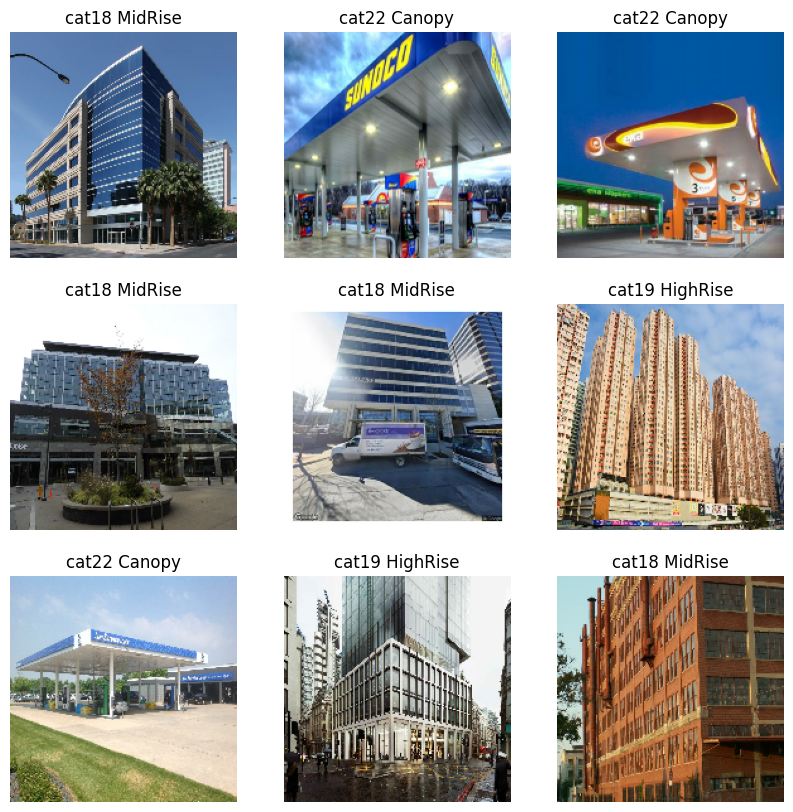

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2.6154987e-05 1.0


In [12]:
num_classes = len(class_names)

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,990,575 (15.22 MB)

 Trainable params: 3,990,575 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
136/136 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - accuracy: 0.2790 - loss: 2.0046 - val_accuracy: 0.2660 - val_loss: 3.8569
Epoch 2/40
136/136 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.5147 - loss: 1.3726 - val_accuracy: 0.3177 - val_loss: 3.4648
Epoch 3/40
136/136 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6284 - loss: 1.0550 - val_accuracy: 0.2767 - val_loss: 4.0510
Epoch 4/40
136/136 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7507 - loss: 0.7267 - val_accuracy: 0.3514 - val_loss: 4.7340
Epoch 5/40
136/136 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8708 - loss: 0.3815 - val_accuracy: 0.3818 - val_loss: 5.0615
Epoch 6/40
136/136 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9227 - loss: 0.2422 - val_accuracy: 0.3588 - val_loss: 5.1342
Epoch 7/40
136/136 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9466 - loss: 0.1914 - val_accuracy: 0.3768 - val_loss: 6.7619
Epoch 8/40
136/136 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9594 - loss: 0.1416 - val_accu

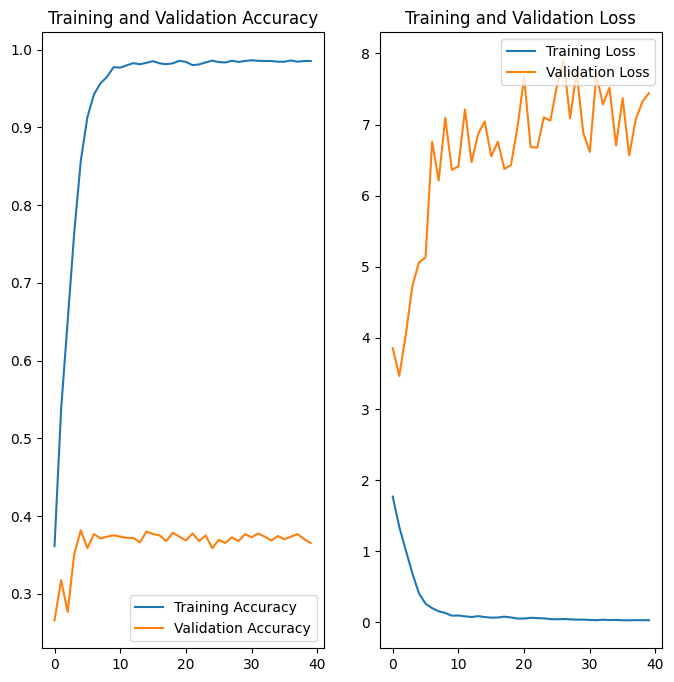

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
#Calculate accracy f1 score orecision and recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

#Calculate precision
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
precision = precision_score(y_true, y_pred, average='macro')
print("Precision: ", precision)

#Calculate recall
recall = recall_score(y_true, y_pred, average='macro')
print("Recall: ", recall)

#Calculate f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 score: ", f1)

#Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: ", accuracy)

#Calcualte confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix: \n", cm)



39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 334ms/step
Precision:  0.2436996127252345
Recall:  0.27173415783436067
F1 score:  0.20038269553933297
Accuracy:  0.36535303776683087
Confusion matrix: 
 [[  0   0   0   0   0   0   0   0   2  17   4  26   9   3   6]
 [  0   0   0   0   0   0   0   0   2   6   1   3  16  12   0]
 [  0   0   0   0   0   0   0   0   2   5   2  32  73  31  27]
 [  0   0   0   1   0   0   0   0   1   6   5  10  37  22  18]
 [  0   0   0   0   0   0   0   0   0   8   0   8   5   3   1]
 [  0   0   0   0   0   0   0   0   0   4   0  13  23   9  12]
 [  0   0   0   0   0   0   0   0   1   2   1   5   8   1   3]
 [  0   0   0   0   0   0   0   0   0   0   0   3  19   4   0]
 [  0   0   0   0   0   0   0   0  14  25   6  12  14   3   4]
 [  0   0   0   0   0   0   0   0   2 105  16  13   4   1   2]
 [  0   0   0   0   0   0   0   0   0  26  66   1   6   2   0]
 [  1   0   0   0   0   0   0   0   4  20   6  45  21   6   2]
 [  0   0   0   0   0   0   0   0   1   3   3   2 134   6  1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
